**Instituto de Informática - UFG**

Disciplina: Inteligência Artificial Aplica a Saude

Prof. 
Arlindo Galvão

---

Aluna(o): 
Juliana Resplande

---


In [2]:
!pip install -U scikit-learn

from google.colab import drive
from sklearn import set_config

set_config(display="diagram")
drive.mount('/content/drive/')

DATA_DIR = 'drive/MyDrive/400X/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
import os

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.calibration import CalibrationDisplay
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from tqdm.autonotebook import tqdm
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    classification_report,
    RocCurveDisplay,
    DetCurveDisplay,
    SCORERS,
)

import numpy as np
import cv2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  if __name__ == '__main__':


In [4]:
def images2features(dir, shape=(32, 32, 3)):
    features = np.zeros(shape[0] * shape[1] * shape[2],)

    image_files = os.listdir(dir)
    print(dir, len(image_files))
    for image_file in tqdm(image_files, desc='images'):
        image_path = os.path.join(dir, image_file)
        image = cv2.imread(image_path)
        resized_image = cv2.resize(image, shape[:2], interpolation=cv2.INTER_AREA)

        features = np.vstack([features, resized_image.flatten()])

    return features


data = dict()
for image_class in tqdm(['benign', 'malignant'], desc='classes'):
  image_dir = os.path.join(DATA_DIR, image_class)
  data[image_class] =  images2features(image_dir)
  data[image_class] =  np.delete(data[image_class], 0, 0)

classes:   0%|          | 0/2 [00:00<?, ?it/s]

drive/MyDrive/400X/benign 588


images:   0%|          | 0/588 [00:00<?, ?it/s]

drive/MyDrive/400X/malignant 1232


images:   0%|          | 0/1232 [00:00<?, ?it/s]

In [5]:
from sklearn.model_selection import train_test_split

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    data['benign'],
    np.ones(data['benign'].shape[0]),
    test_size=0.25,
    shuffle=True
)

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    data['malignant'],
    np.zeros(data['malignant'].shape[0]),
    test_size=0.25,
    shuffle=True
)

print(X_train_b.shape, X_test_b.shape, y_train_b.shape, y_test_b.shape)
print(X_train_m.shape, X_test_m.shape, y_train_m.shape, y_test_m.shape)

X_train = np.concatenate([X_train_b, X_train_m])
y_train = np.concatenate([y_train_b, y_train_m])

X_test = np.concatenate([X_test_b, X_test_m])
y_test = np.concatenate([y_test_b, y_test_m])

(441, 3072) (147, 3072) (441,) (147,)
(924, 3072) (308, 3072) (924,) (308,)


In [18]:
def train_models(X_train, y_train, models, models_params): 
  trained_models = []
  for idx, model in enumerate(tqdm(models)):
    model_params = models_params[idx]

    trained_model = GridSearchCV(
      model,
      model_params,
      scoring='accuracy',
      cv=5,
      verbose=1
    )
    
    trained_model.fit(X_train, y_train) 
    trained_models.append(trained_model)

  return trained_models

def eval_trained_models(X_test, y_test, trained_models):
  for trained_model in tqdm(trained_models):
    print(f'Evaluating {trained_model}')
    Y_test = trained_model.predict(X_test)
    
    print(classification_report(y_test, Y_test))

    displays = [
      ConfusionMatrixDisplay,
      PrecisionRecallDisplay,
      DetCurveDisplay,
      CalibrationDisplay,
    ]    

    for display in displays:
      display.from_predictions(y_test, Y_test)
    
  plt.show()

In [10]:
model = MLPClassifier(
    verbose=0,
    alpha=1e-05,
    shuffle=True,
    solver='adam',
    max_iter=1000,
    batch_size=200,
    random_state=42,
) 

model_params = {
    'hidden_layer_sizes': [
        (100),
        (100,20),
        (100,50),
        (100, 80),
        (200),
        (200, 20),
        (200, 50),
        (200, 70, 30),
        (200, 100, 50),
        (200, 120, 100),
        (220, 140, 120)
      ]
}


In [11]:
trained_models = train_models(X_train, y_train, [model], [model_params])

  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 11 candidates, totalling 55 fits


  0%|          | 0/1 [00:00<?, ?it/s]

Evaluating GridSearchCV(cv=5,
             estimator=MLPClassifier(alpha=1e-05, batch_size=200, max_iter=1000,
                                     random_state=42, verbose=0),
             param_grid={'hidden_layer_sizes': [100, (100, 20), (100, 50),
                                                (100, 80), 200, (200, 20),
                                                (200, 50), (200, 70, 30),
                                                (200, 100, 50), (200, 120, 100),
                                                (220, 140, 120)]},
             scoring='accuracy', verbose=1)
              precision    recall  f1-score   support

         0.0       0.85      0.91      0.88       308
         1.0       0.78      0.67      0.72       147

    accuracy                           0.83       455
   macro avg       0.82      0.79      0.80       455
weighted avg       0.83      0.83      0.83       455



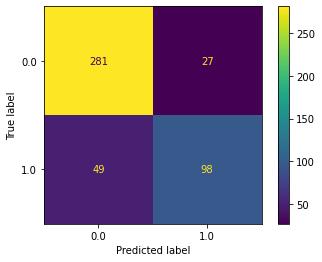

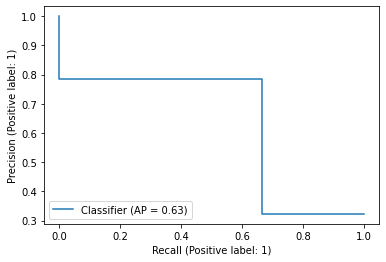

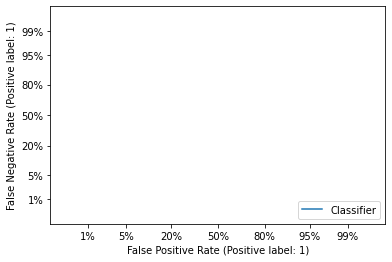

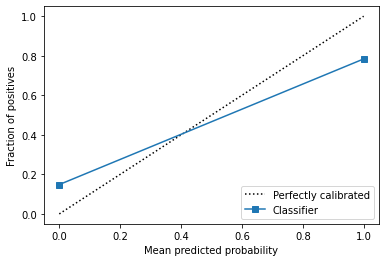

In [19]:
eval_trained_models(X_test, y_test, trained_models)

In [13]:
clf = trained_models[0]
clf

GridSearchCV(cv=5,
             estimator=MLPClassifier(alpha=1e-05, batch_size=200, max_iter=1000,
                                     random_state=42, verbose=0),
             param_grid={'hidden_layer_sizes': [100, (100, 20), (100, 50),
                                                (100, 80), 200, (200, 20),
                                                (200, 50), (200, 70, 30),
                                                (200, 100, 50), (200, 120, 100),
                                                (220, 140, 120)]},
             scoring='accuracy', verbose=1)

In [15]:
clf.best_estimator_

MLPClassifier(alpha=1e-05, batch_size=200, hidden_layer_sizes=(200, 100, 50),
              max_iter=1000, random_state=42, verbose=0)

In [21]:
import pandas as pd

clf_train_results = pd.DataFrame(clf.cv_results_)
clf_train_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_hidden_layer_sizes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,18.390964,10.910955,0.008996,0.000107,100,{'hidden_layer_sizes': 100},0.673993,0.677656,0.677656,0.699634,0.706960,0.687179,0.013429,8
1,4.349587,1.294844,0.012229,0.006568,"(100, 20)","{'hidden_layer_sizes': (100, 20)}",0.673993,0.849817,0.677656,0.842491,0.769231,0.762637,0.076289,2
2,4.016595,1.230602,0.010393,0.002384,"(100, 50)","{'hidden_layer_sizes': (100, 50)}",0.805861,0.666667,0.758242,0.677656,0.761905,0.734066,0.053364,5
3,5.165532,1.315089,0.009276,0.000053,"(100, 80)","{'hidden_layer_sizes': (100, 80)}",0.813187,0.604396,0.754579,0.604396,0.710623,0.697436,0.082644,7
4,9.864301,2.585109,0.014124,0.000062,200,{'hidden_layer_sizes': 200},0.736264,0.626374,0.739927,0.725275,0.699634,0.705495,0.041995,6
5,7.694236,2.228536,0.017129,0.005804,"(200, 20)","{'hidden_layer_sizes': (200, 20)}",0.794872,0.787546,0.791209,0.615385,0.725275,0.742857,0.068701,3
6,6.387158,1.200212,0.014786,0.000518,"(200, 50)","{'hidden_layer_sizes': (200, 50)}",0.695971,0.816850,0.608059,0.556777,0.692308,0.673993,0.088672,9
7,6.259308,0.567954,0.014902,0.000148,"(200, 70, 30)","{'hidden_layer_sizes': (200, 70, 30)}",0.827839,0.677656,0.483516,0.769231,0.549451,0.661538,0.129436,10
8,9.406573,2.665301,0.015654,0.001221,"(200, 100, 50)","{'hidden_layer_sizes': (200, 100, 50)}",0.673993,0.681319,0.794872,0.860806,0.805861,0.763370,0.073501,1
9,6.822261,2.125352,0.015394,0.000095,"(200, 120, 100)","{'hidden_layer_sizes': (200, 120, 100)}",0.633700,0.842491,0.677656,0.673993,0.362637,0.638095,0.155260,11


In [28]:
import plotly.express as px

px.scatter(clf_train_results, x='rank_test_score', y='mean_test_score', color='param_hidden_layer_sizes')